In [9]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score

Questions : compare grid, random and Bayesian optimization in terms of 
 - time - how long does it take to get 'close' to the optimal values
 - results - in a limited number of runs which does best in terms of score
 - applicability 

In [2]:
DATA_PATH = Path('data/')

train = pd.read_csv(DATA_PATH/'train.csv')
test = pd.read_csv(DATA_PATH/'test.csv')
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


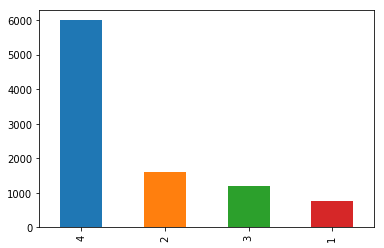

In [14]:
# Target - the target is an ordinal variable indicating groups of income levels. 
# 1 = extreme poverty 
# 2 = moderate poverty 
# 3 = vulnerable households 
# 4 = non vulnerable households

train.Target.value_counts().plot(kind='bar');

In [10]:
pd.DataFrame(train.isnull().sum() / len(train)).sort_values(0, ascending=False)[:10]

,0
rez_esc,0.829549
v18q1,0.768233
v2a1,0.717798
SQBmeaned,0.000523
meaneduc,0.000523
Id,0.000000
hogar_adul,0.000000
parentesco10,0.000000
parentesco11,0.000000
parentesco12,0.000000


In [15]:
train.dtypes.value_counts()

int64      130
float64      8
object       5
dtype: int64

In [3]:
def preprocess(df):
    """
    Main feature engineering function.
    """
    def mk_categoricals(df, prefixes=None, subsets=None):
        """
        Converts one-hot-encoded categorical to true categorical.
        prefixes: list of prefixes of one-hot-encoded categorical variables
                  e.g. for variables
                      abastaguadentro, =1 if water provision inside the dwelling
                      abastaguafuera, =1 if water provision outside the dwelling
                      abastaguano, =1 if no water provision
                  we provide prefix "abastagua"
        subsets: dictionary {name_of_feature: [columns], ...}
                 e.g. for variables
                     public, "=1 electricity from CNFL,  ICE,  ESPH/JASEC"
                     planpri, =1 electricity from private plant
                     noelec, =1 no electricity in the dwelling
                     coopele, =1 electricity from cooperative
                 we provide {"electricity": ['public', 'planpri', 'noelec', 'coopele']}
        """
        def mk_category(dummies):
            assert (dummies.sum(axis=1) <= 1).all()
            nans = dummies.sum(axis=1) != 1
            if nans.any():
                dummies = dummies.assign(_na=nans.astype(int))
            return dummies.idxmax(axis=1).astype('category')

        categoricals = pd.DataFrame()

        if prefixes:
            for prefix in prefixes:
                columns = df.columns[df.columns.str.startswith(prefix)]
                categoricals[prefix] = mk_category(df[columns])
        if subsets:
            for feature_name, subset in subsets.items():
                categoricals[feature_name] = mk_category(df[subset])

        return categoricals
    groupper = df.groupby('idhogar')
    interactions = (pd.DataFrame(dict(
                    head_escolari=df.parentesco1 * df.escolari,
                    head_female=df.parentesco1 * df.female,
                    head_partner_escolari=df.parentesco2 * df.escolari))
                    .groupby(df.idhogar)
                    .max())
    # basic interaction features
    
    my_features = (groupper.mean()[['escolari', 'age', 'hogar_nin', 
                                    'hogar_total', 'epared3', 'epared1',
                                    'etecho3', 'etecho1', 'eviv3', 'eviv1',
                                    'male',
                                    'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 
                                    'r4m3',
                                    'r4t1', 'r4t2', 'r4t3', 'v2a1', 'rooms', 
                                    'bedrooms',
                                    'meaneduc', 
                                    'SQBdependency', 'rez_esc', 'refrig', 
                                    'tamviv', 'overcrowding']]
                   .join(groupper.std()[['escolari', 'age']], 
                         rsuffix='_std')
                   .join(groupper[['escolari', 'age']].min(), rsuffix="_min")
                   .join(groupper[['escolari', 'age']].max(), rsuffix="_max")
                   .join(groupper[['dis']].sum(), rsuffix="_sum")
                   # partially based on
                   # https://www.kaggle.com/taindow/predicting-poverty-levels-with-r
                   .assign(child_rate=lambda x: x.hogar_nin / x.hogar_total,
                           wrf=lambda x: x.epared3 - x.epared1 +
                                         x.etecho3 - x.etecho1 +
                                         x.eviv3 - x.eviv1,
                           # wrf is an integral feature that measure
                           # quality of the house
                           escolari_range=lambda x: x.escolari_max - x.escolari_min,
                           age_range=lambda x: x.age_max - x.age_min,
                           rent_per_individual=lambda x: x.v2a1 / x.r4t3,
                           rent_per_child=lambda x: x.v2a1 / x.r4t1,
                           rent_per_over65=lambda x: x.v2a1 / x.r4t3,
                           rent_per_room=lambda x: x.v2a1 / x.rooms,
                           rent_per_bedroom=lambda x: x.v2a1 / x.bedrooms,
                           rooms_per_individual=lambda x: x.rooms / x.r4t3,
                           rooms_per_child=lambda x: x.rooms / x.r4t1,
                           bedrooms_per_individual=lambda x: x.bedrooms / x.r4t3,
                           bedrooms_per_child=lambda x: x.bedrooms / x.r4t1,
                           years_schooling_per_individual=lambda x: x.escolari / x.r4t3,
                           years_schooling_per_adult=lambda x: x.escolari / (x.r4t3 - x.r4t1),
                           years_schooling_per_child=lambda x: x.escolari / x.r4t3
                          )
                   .drop(['hogar_nin', 'hogar_total', 'epared3', 'epared1',
                                   'etecho3', 'etecho1', 'eviv3', 'eviv1'], 
                         axis=1)
                   .join(interactions)
                   .join(groupper[['computer', 'television', 
                                   'qmobilephone', 'v18q1']]
                         .mean().sum(axis=1).rename('technics'))
                   # we provide integral technical level as a new feature 
                   .assign(technics_per_individual=lambda x: x.technics / x.r4t3,
                           technics_per_child=lambda x: x.technics / x.r4t1)
                   .join(mk_categoricals(groupper.mean(), 
                                prefixes=['lugar', 'area', 'tipovivi', 
                                          'energcocinar', 
                                          'sanitario', 'pared', 'piso',
                                          'abastagua'],
                                subsets={'electricity': ['public', 
                                                         'planpri', 
                                                         'noelec', 
                                                         'coopele']}))
                  )
    return my_features

In [27]:
# y = train.groupby('idhogar').Target.mean().astype(int)
# X_train, X_val, y_train, y_val = train_test_split(train.drop('Target', axis=1), y, test_size=0.1, stratify=y)

# X_train = preprocess(X_train)
# X_train = preprocess(X_val)
# X_test = preprocess(test)

# y_train = y_train.values - 1
# y_val = y_val.values - 1


X_train = preprocess(train)
X_test = preprocess(test)

y_train = train.groupby('idhogar').Target.mean().astype(int)
y_train = y_train.values - 1

In [30]:
# baseline model

def f1_score_weighted(preds, dtrain):
    labels = dtrain.get_label()
    preds = pred.reshape(len(set(labels)), -1)
    preds = preds.argmax(axis = 1)
    f_score = f1_score(labels, preds,  average='weighted')
    return 'f1_score', f_score, True

train_data = lgb.Dataset(X_train, y_train)


default_param = {
    'objective': 'multiclass',
    'seed': 100,
    'num_classes': 4,
}

cv_results = lgb.cv(default_param, train_data, num_boost_round=10000, #feval=f1_score_weighted,
                    early_stopping_rounds=100, nfold=5, verbose_eval=False)

In [31]:
model = lgb.train(default_param, train_data, num_boost_round=len(cv_results['multi_logloss-mean']))
preds = model.predict(X_train)
baseline_f1 = f1_score(y_train, preds.argmax(1),  average='weighted')
print('Five Fold baseline f1: {}'.format(baseline_f1))

Five Fold baseline f1: 0.8503008929259187


In [32]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe
from hyperopt import STATUS_OK
import time

In [33]:
def objective(params, counter=0, gpu=False, nfold=5):
    
    bagging_fraction = params['boosting_type'].get('bagging_fraction', 1.0)
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['bagging_fraction'] = bagging_fraction
    
    # convert int params to ints 
    int_cols = ['max_bin', 'min_data_in_leaf', 'num_leaves', 'subsample_for_bin']
    for key, val in params.items():
        if key in int_cols:
            params[key] = int(params[key])
            
    # throw on gpu if available 
    if gpu: params['device'] = 'gpu'
    
    # problem specific params 
    params['objective'] = 'multiclass'
    params['num_classes'] = 4
    
    if 'num_boost_round' in params: del params['num_boost_round']
    
    start = time.time()
    
    cv_results = lgb.cv(params, train_data, num_boost_round=100000, nfold=nfold, 
                       early_stopping_rounds=100, seed=100)
    num_boost_rounds = len(cv_results['multi_logloss-mean'])
    params['num_boost_round'] = num_boost_rounds
    best_score = cv_results['multi_logloss-mean'][-1]
    
    
    return {'loss': best_score, 'params': params, 'iteration': counter,
            'train_time': time.time()-start, 'status': STATUS_OK}
    
        



param_space = {
    'num_leaves': hp.quniform('num_leaves', 20, 200, 1), # num_leaves = 2^(max_depth)
    'feature_fraction': hp.quniform('feature_fraction', 0.01, 0.99, .01),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 0, 400, 5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'max_bin': hp.quniform('max_bin', 200, 500, 25),
#     'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
#     'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
#     'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
#     'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'boosting_type': hp.choice('boosting_type', 
                     [{'boosting_type': 'gbdt', 'bagging_fraction': hp.uniform('gdbt_bagging_fraction', 0.5, 1)}, 
                      {'boosting_type': 'dart', 'bagging_fraction': hp.uniform('dart_bagging_fraction', 0.5, 1)},
                      {'boosting_type': 'goss', 'bagging_fraction': 1.0}]),        
}



In [34]:
from hyperopt import fmin
from hyperopt import Trials

trials = Trials()

best_bay_params = fmin(objective, param_space, tpe.suggest, max_evals=10, trials=trials)

In [38]:
param_grid = {
    'num_leaves': np.arange(20, 200, 1), 
    'feature_fraction': list(np.linspace(0.01, 0.99, 100)),
    'min_data_in_leaf': list(np.arange(5, 400, 5)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=1000)),
    'subsample_for_bin': list(np.arange(20000, 300000, 20000)),
    'max_bin': list(np.arange(200, 500, 25)),
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'bagging_fraction': list(np.linspace(0.5, 1, 100))  
}

random_params = {k: np.random.choice(v, 1)[0] for k, v in param_grid.items()}
random_params['bagging_fraction'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['bagging_fraction']
random_params

{'bagging_fraction': 0.7676767676767677,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.2871717171717172,
 'learning_rate': 0.02310120685875656,
 'max_bin': 250,
 'min_data_in_leaf': 310,
 'num_leaves': 65,
 'subsample_for_bin': 40000}

In [241]:
import itertools

def findMiddle(input_list, size=6):
    middle = float(len(input_list)) / 2
    if middle % 2 != 0:
        return input_list[int(middle - .5)]
    else:
        return (input_list[int(middle - (size / 2)):int(middle + (size / 2))])
    


i = 0
keys, values = zip(*param_grid.items())
for v in itertools.product(*values):
    params = dict(zip(keys, v))
    print(params)
    i += 1
    
    if i == 5:
        break

{'num_leaves': 20, 'feature_fraction': 0.01, 'min_data_in_leaf': 5, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'max_bin': 200, 'boosting_type': 'gbdt', 'bagging_fraction': 0.5}
{'num_leaves': 20, 'feature_fraction': 0.01, 'min_data_in_leaf': 5, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'max_bin': 200, 'boosting_type': 'gbdt', 'bagging_fraction': 0.5050505050505051}
{'num_leaves': 20, 'feature_fraction': 0.01, 'min_data_in_leaf': 5, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'max_bin': 200, 'boosting_type': 'gbdt', 'bagging_fraction': 0.51010101010101}
{'num_leaves': 20, 'feature_fraction': 0.01, 'min_data_in_leaf': 5, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'max_bin': 200, 'boosting_type': 'gbdt', 'bagging_fraction': 0.5151515151515151}
{'num_leaves': 20, 'feature_fraction': 0.01, 'min_data_in_leaf': 5, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'max_bin': 200, 'b

In [40]:
def findMiddle(input_list, size=6):
    middle = float(len(input_list)) / 2
    if len(input_list) > 3:
        return (input_list[int(middle - (size / 2)):int(middle + (size / 2))])
    return input_list

def spaced_array(grid, total=5):
    N = len(grid)
    if N > total:
        return grid[::int(N/total)]
    return grid

i = 0
for k, v in param_grid.items():
    print(spaced_array(param_grid[k], 5))
    i += len(spaced_array(param_grid[k], 5))
    
for k, v in param_grid.items():
    print(findMiddle(param_grid[k]))

[ 20  56  92 128 164]
[0.01, 0.207979797979798, 0.40595959595959596, 0.6039393939393939, 0.8019191919191919]
[5, 80, 155, 230, 305, 380]
[0.004999999999999999, 0.01257101674071398, 0.031606092379062256, 0.07946414328114888, 0.19978901509476346]
[20000, 60000, 100000, 140000, 180000, 220000, 260000]
[200, 250, 300, 350, 400, 450]
['gbdt', 'goss', 'dart']
[0.5, 0.601010101010101, 0.702020202020202, 0.803030303030303, 0.9040404040404041]
[107 108 109 110 111 112]
[0.47525252525252526, 0.4851515151515151, 0.495050505050505, 0.5049494949494949, 0.5148484848484849, 0.5247474747474747]
[185, 190, 195, 200, 205, 210]
[0.04942708510959786, 0.04965545906874897, 0.049884888211816, 0.050115377414193266, 0.05034693157380137, 0.05057955561119148]
[100000, 120000, 140000, 160000, 180000, 200000]
[275, 300, 325, 350, 375, 400]
['gbdt', 'goss', 'dart']
[0.7373737373737375, 0.7424242424242424, 0.7474747474747475, 0.7525252525252526, 0.7575757575757576, 0.7626262626262627]


In [299]:
def spaced_array(grid, total=5):
    N = len(grid)
    if N > 3:
        return grid[::int(len(grid) / total)]
    return grid

for k, v in param_grid.items():
    print(spaced_array(param_grid[k], 5))

[ 20  56  92 128 164]
[0.01, 0.207979797979798, 0.40595959595959596, 0.6039393939393939, 0.8019191919191919]
[5, 80, 155, 230, 305, 380]
[0.004999999999999999, 0.01257101674071398, 0.031606092379062256, 0.07946414328114888, 0.19978901509476346]
[20000, 60000, 100000, 140000, 180000, 220000, 260000]
[200, 250, 300, 350, 400, 450]
['gbdt', 'goss', 'dart']
[0.5       0.6010101 0.7020202 0.8030303 0.9040404]


In [43]:
trials.results

[{'iteration': 0,
  'loss': 0.8251860786733551,
  'params': {'bagging_fraction': 1.0,
   'boosting_type': 'goss',
   'feature_fraction': 0.89,
   'learning_rate': 0.01075284807261621,
   'max_bin': 375,
   'min_data_in_leaf': 125,
   'num_boost_round': 983,
   'num_classes': 4,
   'num_leaves': 101,
   'objective': 'multiclass',
   'subsample_for_bin': 180000,
   'verbose': 1},
  'status': 'ok',
  'train_time': 3.607090473175049},
 {'iteration': 0,
  'loss': 0.8498445300446702,
  'params': {'bagging_fraction': 1.0,
   'boosting_type': 'goss',
   'feature_fraction': 0.3,
   'learning_rate': 0.37425921513171634,
   'max_bin': 300,
   'min_data_in_leaf': 200,
   'num_boost_round': 21,
   'num_classes': 4,
   'num_leaves': 22,
   'objective': 'multiclass',
   'subsample_for_bin': 260000,
   'verbose': 1},
  'status': 'ok',
  'train_time': 0.2663004398345947},
 {'iteration': 0,
  'loss': 0.8225850466716246,
  'params': {'bagging_fraction': 0.7581994008231714,
   'boosting_type': 'dart',
   